<a href="https://colab.research.google.com/github/KasMasVan/Codes-and-Notes-for-Some-Public-Coureses/blob/main/RLbook2020/chapter2/RL_chapter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [263]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Exercise  2.5

In [295]:
#all q*(a) start out equal, and then take independent random walks
class multi_armed_bandit():
  def __init__(self, arm=10, q_mean=0, q_var=1, epsilon=0.1, steps=10000, constant_step_size=False):
    self.arm = arm 
    #q_mean and q_var are used to sample true values of each action
    self.q_mean = q_mean 
    self.q_var = q_var
    #epsilon greedy 
    self.epsilon = epsilon
    self.steps = steps
    self.true_value, self.true_values, self.estimate_values, self.times_selected = self.init_bandit()
    self.reward_hisory = np.zeros((self.steps, )) #store reward for plotting
    self.optimal_action_hisotry = np.zeros((self.steps, ))#store whether the selected actions are optimal
    self.current_step = 0 #range from 0 to self.steps -1
    self.constant_step_size = constant_step_size

  def init_bandit(self):
    true_value = self.q_var * np.random.randn(1) + self.q_mean 
    true_values = np.full(self.arm, true_value) #q*(a) 
    estimate_values = np.zeros(self.arm) #Q(a): estimate of q*(a)
    times_selected = np.zeros(self.arm, dtype='int32') #N(a)
    return true_value, true_values, estimate_values, times_selected
  
  def one_step(self):
    assert self.current_step < self.steps
    do_random = np.random.binomial(1, self.epsilon)
    if do_random:
      # randomly choose one action, [0, 10)
      action = np.random.randint(0, self.arm)
    else:
      #choose argmax Q(a)
      #if there are multiple highest estiamte value, randomly choose one
      max_actions = np.squeeze(np.argwhere(self.estimate_values == np.amax(self.estimate_values)), axis=-1)
      action = np.random.choice(max_actions)
    #calculate reward and update
    reward = np.random.randn(1) + self.true_values[action] 
    self.times_selected[action] += 1
    if self.constant_step_size:
      stepsize = 0.1
    else:
      stepsize = 1 / self.times_selected[action]
    self.estimate_values[action] = self.estimate_values[action] + stepsize * (reward - self.estimate_values[action])

    self.reward_hisory[self.current_step] = reward
    if self.true_values[action] == np.amax(self.true_values):
      self.optimal_action_hisotry[self.current_step] = True
    self.current_step += 1
    #add a normally distributed increment to all q*(a) on each step
    random_walk = np.random.randn(self.arm) * 0.1
    self.true_values += random_walk
  
  def play(self, total_steps):
    assert total_steps <= self.steps
    for i in range(total_steps):
      self.one_step()

  def __str__(self):
    return (f'true value: {self.true_value}\ntrue_values: {self.true_values}\n'
    f'estimate_values: {self.estimate_values}\ntimes_selected: {self.times_selected}')

In [327]:
#sample average, incrementally computed
num_bandit = 2000
bandit_list_sample = []
for i in tqdm(range(num_bandit)):
  one_bandit = multi_armed_bandit()
  one_bandit.play(10000)
  bandit_list_sample.append(one_bandit)

#constant step-size with a=0.1
bandit_list_constant = []
for i in tqdm(range(num_bandit)):
  one_bandit = multi_armed_bandit(constant_step_size=True)
  one_bandit.play(10000)
  bandit_list_constant.append(one_bandit)

100%|██████████| 2000/2000 [19:45<00:00,  1.69it/s]


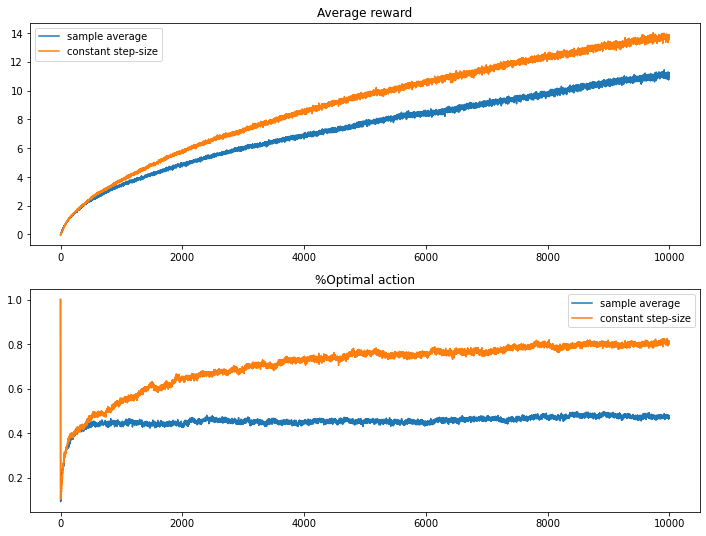

In [328]:
reward_sample = [item.reward_hisory for item in bandit_list_sample]
avg_reward_sample = sum(reward_sample) / num_bandit
optimal_action_sample  = [item.optimal_action_hisotry for item in bandit_list_sample]
avg_optimal_action_sample = sum(optimal_action_sample) / num_bandit

reward_constant = [item.reward_hisory for item in bandit_list_constant]
avg_reward_constant = sum(reward_constant) / num_bandit
optimal_action_constant = [item.optimal_action_hisotry for item in bandit_list_constant]
avg_optimal_action_constant = sum(optimal_action_constant) / num_bandit

#plot
fig, axs = plt.subplots(2, figsize=(12,9))
axs[0].set_title('Average reward')
axs[0].plot(avg_reward_sample, label='sample average')
axs[0].plot(avg_reward_constant, label='constant step-size')
axs[0].legend()
axs[1].set_title('%Optimal action')
axs[1].plot(avg_optimal_action_sample, label='sample average')
axs[1].plot(avg_optimal_action_constant, label='constant step-size')
axs[1].legend()
fig.savefig('2_5.png')

## Exercise 2.11

In [337]:
epsilon_list = [2**i for i in range(-7, 1)]

In [360]:
num_steps = 200000
bandit_list_epsilon = []
for epsilon in tqdm(epsilon_list):
  one_bandit = multi_armed_bandit(epsilon=epsilon, steps=num_steps)
  one_bandit.play(num_steps)
  bandit_list_epsilon.append(one_bandit)

bandit_list_epsilon_constant = []
for epsilon in tqdm(epsilon_list):
  one_bandit = multi_armed_bandit(epsilon=epsilon, steps=num_steps, constant_step_size=True)
  one_bandit.play(num_steps)
  bandit_list_epsilon_constant.append(one_bandit)

100%|██████████| 8/8 [01:26<00:00, 10.84s/it]


In [361]:
reward_epsilon = [item.reward_hisory[100000:] for item in bandit_list_epsilon]
avg_reward_epsilon = [sum(item) / len(item) for item in reward_epsilon]

reward_epsilon_constant = [item.reward_hisory[100000:] for item in bandit_list_epsilon_constant]
avg_reward_epsilon_constant = [sum(item) / len(item) for item in reward_epsilon_constant]

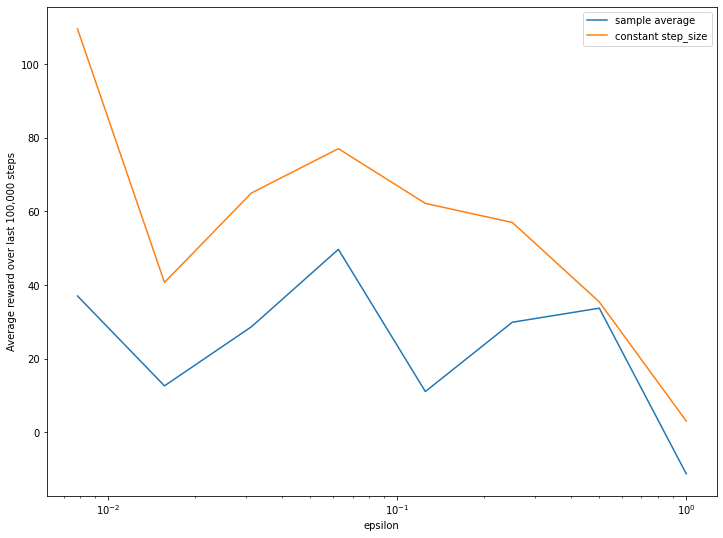

In [362]:
#plot
fig, axs = plt.subplots(1, figsize=(12,9))
axs.set_xlabel('epsilon')
axs.set_xscale('log')
axs.set_ylabel('Average reward over last 100,000 steps')
axs.plot(epsilon_list, avg_reward_epsilon, label='sample average')
axs.plot(epsilon_list, avg_reward_epsilon_constant, label='constant step_size')
axs.legend()